In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from numpy import *

Actions = {0:'up',1:'right',2:'down',3:'left'}

1. Start with 2 low num tiles (majority of time is #2)
2. Populate one free tile at random after move with low num tile (majority #2)
3. Check to see if no available moves 

In [2]:
def add_two(game_board):
    if np.count_nonzero(game_board) == 16: return game_board
    y = np.random.randint(0, 4)
    x = np.random.randint(0, 4)
    while game_board[y][x] != 0:
        y = np.random.randint(0, 4)
        x = np.random.randint(0, 4)
    # Assign 
    if np.random.random()<0.9: game_board[y][x] = 2
    else: game_board[y][x] = 4
    return game_board

def gen_board():
    game_board = np.zeros([4,4])
    add_two(game_board)
    add_two(game_board)
    return game_board

In [3]:
def up(game_board):
    for i in range(3,0,-1):
        for j in range(4):
            if game_board[i-1,j] == 0: 
                game_board[i-1,j] = game_board[i,j]
                game_board[i,j] = 0

    for i in range(3,0,-1):
        for j in range(4):
            if game_board[i-1,j] == game_board[i,j]: 
                game_board[i-1,j] = game_board[i,j] * 2
                game_board[i,j] = 0
    
    return game_board

def step_game(action,game_board):
    init_board = np.copy(game_board)

    if action == 'up': game_board = up(game_board)
    elif action == 'down':
        game_board = np.rot90(game_board, 2)
        game_board = up(game_board)
        game_board = np.rot90(game_board, 2)
    elif action == 'right':
        game_board = np.rot90(game_board, 1)
        game_board = up(game_board)
        game_board = np.rot90(game_board, 3)
    elif action == 'left':
        game_board = np.rot90(game_board, 3)
        game_board = up(game_board)
        game_board = np.rot90(game_board, 1)

    if not(np.array_equal(init_board,game_board)): game_board = add_two(game_board)
    if np.array_equal(init_board,game_board) and np.count_nonzero(game_board) == 16: done = True
    else: done = False


    return game_board, done


In [4]:
def get_state(game_board):
    log_board = ma.log2(game_board).filled(0)
    log_board[log_board>4] = 4
    return log_board.flatten().astype(int)

def get_reward(game_board):
    log_board = ma.log2(game_board).filled(0)
    return log_board.flatten().astype(int).sum()

def get_action(state,Q_val):
    p_epsilon = np.random.uniform(0,1)
    if p_epsilon < 0.1: return np.random.randint(4)
    
    q_s = np.zeros(4)

    for i in range(4): q_s[i] = Q_val[tuple(np.append(state,i))]

    return np.argmax(q_s)


In [8]:
Q_val = np.zeros([5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4])
max_tile = np.zeros(10000)
ep_length = np.zeros(10000)

for episode in tqdm(range(10000)):

    my_board = gen_board()
    state = get_state(my_board)
    done = False

    action = get_action(state,Q_val)

    i = 0
    while not done:
        # Step Environment
        my_board,done = step_game(Actions[action],my_board)
        state_prime = get_state(my_board)
        reward = get_reward(my_board)

        # Get Action e-greedy 
        action_prime = get_action(state_prime,Q_val)
        
        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = reward + 0.9 * Q_val[tuple(np.append(state_prime,action_prime))]-Q_val[tuple(np.append(state,action))]

        Q_val[tuple(np.append(state,action))] = Q_val[tuple(np.append(state,action))] + 0.1*TD_error

        state  = state_prime
        action = action_prime

        i += 1

    ep_length[episode] = i

    max_tile[episode] = my_board.flatten().max()



  1%|          | 652/100000 [00:57<2:25:29, 11.38it/s]


KeyboardInterrupt: 

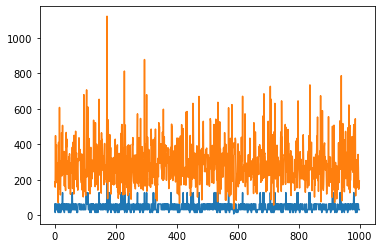

In [6]:
plt.plot(max_tile)
plt.plot(ep_length)

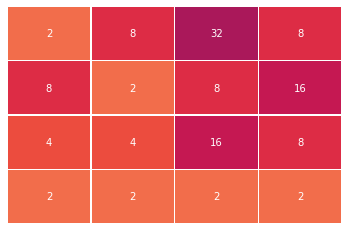

In [7]:
sns.heatmap(my_board+0.1,annot=True, fmt='.0f',linewidths=.5,cbar=False,yticklabels=False,xticklabels=False,norm=colors.LogNorm(vmin=0.1, vmax=2048),cmap=sns.cm.rocket_r);